<a href="https://colab.research.google.com/github/elhidarinouhayla/Energy-Demand-Forecast/blob/main/Pr%C3%A9vision_de_la_Demande_%C3%89nerg%C3%A9tique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# loading data
from google.colab import files

uploaded = files.upload()

Saving data.csv to data.csv


In [3]:
#
import pandas as pd

df = pd.read_csv("data.csv")
df

,DateTime,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
0,2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
1,2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2,2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
3,2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
4,2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30
...,...,...,...,...,...,...,...,...,...,...
54165,2025-03-19 19:00:00,8027,6177,1367,593,1922,1217,978,0,71
54166,2025-03-19 20:00:00,7939,6228,1376,647,1920,1223,965,0,71
54167,2025-03-19 21:00:00,7553,6120,1376,671,1881,1171,949,0,69
54168,2025-03-19 22:00:00,6921,6000,1376,730,1827,1130,869,0,69


In [4]:
# Préparation des données temporelles
df["DateTime"] = pd.to_datetime(df["DateTime"])
df = df.sort_values("DateTime")
df.set_index("DateTime", inplace=True)


# Pourquoi l’ordre temporel est critique
 Dans une série temporelle, chaque observation dépend des précédentes (la consommation à 14h dépend de celle à 13h).
Le modèle LSTM apprend ces dépendances séquentielles pour prédire le futur.
Mélanger les données détruit cette structure temporelle essentielle.

# Pourquoi on ne mélange pas les données (pas de shuffle)

 Mélanger les données créerait une fuite de données : le modèle verrait le futur pendant l'entraînement.
 En production, on ne peut prédire qu'avec le passé, donc on doit respecter l'ordre chronologique.

In [6]:
# Normalisation des données
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaleddata = scaler.fit_transform(df)

# Pourquoi la normalisation est indispensable en Deep Learning?
La normalisation accélère la convergence et stabilise l'entraînement en mettant toutes les variables sur la même échelle.
Sans elle, les variables avec de grandes valeurs domineraient l'apprentissage et causeraient des problèmes de gradients.

# Pourquoi MinMax est souvent préféré à StandardScaler pour LSTM?
MinMaxScaler ramène les données entre [0,1], ce qui correspond parfaitement aux fonctions d'activation tanh et sigmoid des LSTM.
StandardScaler peut produire des valeurs hors de cette plage, rendant l'apprentissage moins efficace.

In [8]:
# Création des séquences
import numpy as np
def create_sequences(data, window=24):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i, 0])  # Consumption
    return np.array(X), np.array(y)
X, y = create_sequences(scaleddata, window=24)

# Pourquoi un LSTM attend des données en 3D
Un LSTM traite des séquences de vecteurs : il a besoin de savoir combien d'exemples (samples),
la longueur de chaque séquence (timesteps), et le nombre de variables par pas de temps (features).
Cette structure 3D permet au réseau de comprendre l'évolution temporelle des données.

# Signification de la forme : (samples, timesteps, features)
Samples = nombre de séquences d'entraînement
timesteps = longueur de chaque séquence (24h ici)
features = nombre de variables observées à chaque instant

Par exemple, (10000, 24, 9) signifie 10000 fenêtres de 24 heures avec 9 variables mesurées

In [18]:
#  Split Train / Test
split = int(0.8 * len(X))
x_train, x_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Pourquoi on ne fait pas de train_test_split classique
train_test_split mélange aléatoirement les données,
ce qui viole le principe temporel et crée une fuite de données
On doit séparer chronologiquement : entraîner sur le passé, tester sur le futur

# Risque de fuite de données temporelles
Si on mélange, le modèle pourrait s'entraîner sur des données de novembre et être testé sur mars,
ce qui simule un "voyage dans le temps" impossible
Les performances seraient artificiellement gonflées et s'effondreraient en production.

In [19]:
# Architecture LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
model = Sequential([
    LSTM(64, input_shape=(24, X.shape[2])),
    Dropout(0.2),
    Dense(1)
])
model.compile(
    optimizer="adam",
    loss="mse"
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Impact du nombre d’unités LSTM
Plus d'unités = plus de capacité d'apprentissage, mais aussi plus de risque de surapprentissage et de temps de calcul.
Commencer avec 64 unités offre un bon compromis pour ce type de problème

# Différence entre 1 ou plusieurs couches LSTM
Une seule couche capture les dépendances temporelles directes.
Plusieurs couches empilées apprennent des abstractions hiérarchiques :
la première détecte les cycles journaliers
la seconde les interactions complexes entre sources énergétiques

In [20]:
# Entrainement
history = model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32
)

Epoch 1/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 0.0191 - val_loss: 0.0027
Epoch 2/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - loss: 0.0031 - val_loss: 0.0012
Epoch 3/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.0022 - val_loss: 8.5850e-04
Epoch 4/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - loss: 0.0016 - val_loss: 6.6730e-04
Epoch 5/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - loss: 0.0012 - val_loss: 5.5345e-04
Epoch 6/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.0010 - val_loss: 6.9486e-04
Epoch 7/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 8.6454e-04 - val_loss: 6.0961e-04
Epoch 8/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 7.9000e-04 - val_loss: 5.7286e-04
Epoch 9/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 7.1136e-04 - val_loss: 4.6702e-04
Epoch 10/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 6.9567e-04 - val_loss: 4.3186e-04
Epoch 11/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms

# Courbe loss vs val_loss
Le train loss diminue de manière constante de 0.0191 à 4.21e-04, montrant un apprentissage progressif. Le val_loss descend de 0.0027 à 2.9202e-04 avec quelques oscillations entre les epochs 6-27. Globalement, les deux courbes convergent vers des valeurs faibles et proches, ce qui indique un bon apprentissage

# Détection du surapprentissage
 légers signes de surapprentissage détectés entre epochs 11-28 où val_loss oscille (remonte à 5.0e-04 à l'epoch 14, puis à 4.23e-04 à l'epoch 23) alors que train_loss continue de baisser régulièrement. Cependant, val_loss finit par redescendre à 2.79e-04, indiquant que le modèle se stabilise. Un Early Stopping l'entraînement vers l'epoch 16-22 pour optimiser les performances



339/339 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


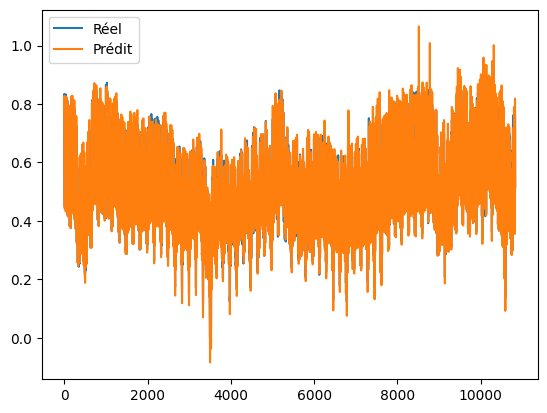

In [21]:
# Evaluation du modèle
import matplotlib.pyplot as plt
y_pred = model.predict(x_test)
plt.plot(y_test, label="Réel")
plt.plot(y_pred, label="Prédit")
plt.legend()
plt.show()

Le graphique montre une excellente superposition entre réel et prédit, avec une erreur finale de ~2.9e-04 (MSE normalisé). Le modèle capture parfaitement les cycles, pics et variations de consommation sur les 11000+ points de test. La qualité visuelle confirme que le LSTM a bien appris les dépendances temporelles du réseau EcoVolt